# TP 5 : Modélisation et résolution d'un problème de classification

On suppose que l'on dispose d'un certain type de données, et on veut être capable de les **classer** en deux groupes. Ce type de problème peut être très facile à réaliser pour un humain, mais toute la question est de savoir comment automatiser cette prise de décision pour l'implémenter sur une machine.

| Un problème simple de classification simple pour un humain | |
|---|---|
| ![](http://www.adventuresofxandd.com/wp-content/uploads/2014/06/1031-2_monster-in-a-box-2.jpg) | ![](https://static.wamiz.com/images/animals/large/naomi-6.jpg) |
| Type de données: photos | Classes possibles : Chat ou chien |

L'objectif de ce TP est de vous montrer comment résoudre ce type problème (en tout cas lorsqu'il n'est pas trop difficile). Dans un premier temps vous vous familiariserez avec le sujet sur des données synthétiques, puis vous travaillerez ensuite avec de vraies données: des photos contenant des caractères écrits à la main.

**Présentation du problème**

Une façon de modéliser ce problème est la suivante: on se retrouve face à une donnée $x \in \mathbb{R}^N$ et on veut lui attribuer une classe. Pour simplifier, lorsqu'on a un problème à deux classes comme dans les exemples ci-dessus, on dit souvent que les deux classes sont $\{-1,+1\}$. 
Par exemple $-1$ pourrait désigner "chien" et $1$ désignerait "chat".

Ce que l'on souhaite donc implémenter est ce que l'on appelle un **classifieur**, c'est-à-dire une fonction $c : \mathbb{R}^N \longrightarrow \{-1,+1\}$ qui prend en entrée une donnée $x \in \mathbb{R}^N$, et qui donne en sortie une étiquette $\pm 1$. Evidemment on ne va pas prendre n'importe quelle fonction $\mathbb{R}^N \longrightarrow \{-1,+1\}$, on veut que notre calssifieur fasse un "bon" travail en classant les données qu'on lui fournit.

**Comment faire ça?**

En pratique on suit le processus suivant: 

*1) Consititution d'une base de données*: on se procure

- Une famille de données $\{x_1, \dots, x_m\} \subset \mathbb{R}^N$ (par exemple tout un tas de photos de chats et de chiens)
- La famille des étiquettes correspndantes $\{y_1, \dots, y_m\} \subset \{ -1,+1\}$, où chaque $y_i$ a été bien choisi par un humain

Par exemple, en reprenant la convention ci-dessus, si $x_{47}$ est une photo de chien, alors $y_{47}=-1$ (rappelons que toute photo peut être vue comme un vecteur de $\mathbb{R}^N$ où $N$ correspond au nombre de pixels de la photo).

*2) La phase d'entraînement*: à partir de cette base de données, on va construire un classifieur $c : \mathbb{R}^N \longrightarrow \{-1,+1\}$, en demandant à ce que ce classifieur verifie, pour tout point de notre base de données, $c(x_i) = y_i$. Ainsi, on espère que si le classifieur fonctionne bien sur notre base de données, alors il fonctionnera également lorsqu'on lui présentera de nouvelles données.

Ce TP se focalisera sur cette phase, le but étant de montrer que derrière ce problème se cache en fait un problème d'optimisation, que l'on va résoudre.

*3) La phase de test*: Une fois que l'on aura trouvé notre classifieur, il faudra bien tester si il marche bien! Pour cela, on se constituera une nouvelle base de données $\{(\hat x_i,\hat y_i)\}$ similaire à celle mentionnée plus haut, et on regardera si l'étiquette prédite $c(\hat x_i)$ est bien égale à $\hat y_i$. On pourra par exemple compter le nombre de fois où le classifieur trouve la bonne réponse, et donc en déduire un pourcentage de succès estimé.

**Rq:** Noter qu'en pratique on ne constitue pas deux bases de données. On construit une grosse base de données une fois pour toute, puis on la divise en deux parties: les données dites "d'entrainement" qui vont servir à construire le classifieur $c$, et d'autre part les données de "test" qui vont permettre d'évaluer si notre classifieur marche bien sur de nouvelles données.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Séparer deux groupes de points dans le plan

## 1. Présentation

**1)** On commence par importer des données

In [2]:
X = np.load('data/donnees_entrainement.npy')

Ces données correspondent à $m$ points de $\mathbb{R}^2$, qui sont rangées dans une matrice à $m$ lignes et 2 colonnes.
Chaque *ligne* de la matrice correspond donc à un point de $\mathbb{R}^2$.
Vous pouvez regarder quelle est la taille de la matrice avec la méthode `X.shape`, ce qui vous permettra de déterminer la valuer de $m$.

In [3]:
X.shape

(200, 2)

In [4]:
m = 200 # à definir

Vu que nos données sont des points du plan, on va pouvoir facilement les visualiser avec la fonction `plt.scatter` de pyplot.

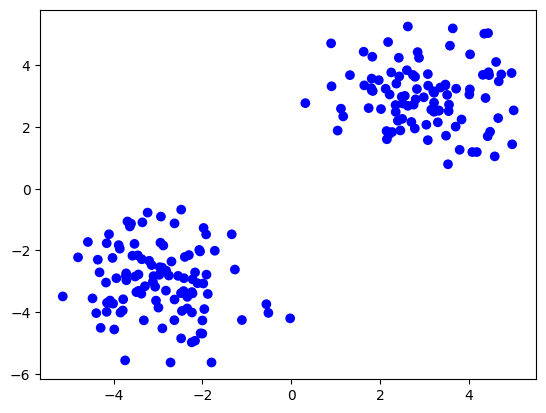

In [5]:
couleur = [None]*m # liste vide de taille m
for k in range(m):
    couleur[k] = 'blue'
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

**2)** Vous devriez être maintenant convaincus que ce jeu de données contient deux groupes de points appartenant à des familles distinctes. Or nous n'en savons rien, à priori, le seul moyen d'en être sur est d'aller regarder les *etiquettes* correspondantes. Importons-les:

In [6]:
Y = np.load('data/etiquettes_entrainement.npy')

Vérifiez que ce vecteur ne contient que des étiquettes $\pm 1$.

In [7]:
Y

array([ 1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
       -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,
       -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1

En adaptant le code de la précédente question, affichez de nouveau ce nuage de points cette fois-ci avec deux couleurs: rouge pour les points avec l'étiquette $-1$, et bleu pour les points avec l'étiquette $+1$.

In [8]:
couleur = [None]*m
for k in range(m):
    if Y[k] == 1:
        couleur[k] = 'blue'
    else:
        couleur[k] = 'red'

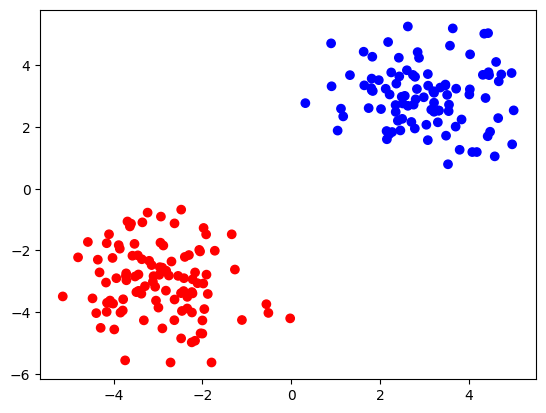

In [9]:
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

**3)** Une approche intuitive pour classer ce problème consiste à tracer une droite qui va séparer ces deux nuages: ainsi fait, on pourra dire que tout nouveau point qui apparaitra d'un côté de la droite sera "rouge" et de l'autre les "bleus".

Ici on va considérer une droite dans $\mathbb{R}^2$ comme étant l'ensemble des points satisfaisant l'équation

$$ D = \{ x \in \mathbb{R}^2 \ | \ \langle a, x \rangle + b =0 \},$$

où $a \in \mathbb{R}^2$ et $b \in \mathbb{R}$ sont à choisir. On notera par la suite $w = (a,b) \in \mathbb{R}^2 \times \mathbb{R}$ le vecteur de paramètres décrivant la droite $D$.

En utilisant le code ci-dessous, ajoutez le tracé d'une droite aux données, et jouez avec la valeur de $w$ pour essayer de trouver la droite qui sépare le mieux les deux classes.

In [10]:
def trace_droite(w):
    # trace la droite des points x vérfiant l'équation <a,x>+b=0
    # où w = (a_1, a_2, b)
    a = w[0:2]
    b = w[2]
    if a[1] == 0:
        alpha, beta = 0, 0
    else:
        alpha = -a[0]/a[1]
        beta = -b/a[1]
    abscisse = np.arange(-5,5,0.1)
    ordonnee = alpha*abscisse + beta
    plt.plot(abscisse, ordonnee)

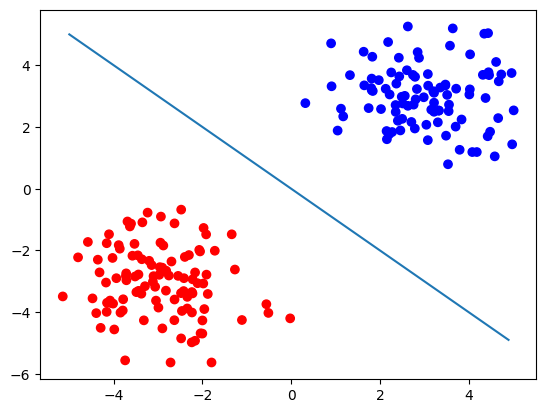

In [11]:
w = np.array([1, 1, 0]) # à modifier
trace_droite(w)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

Pensez-vous que certaines droites sont meilleures que les autres?

## 2. Modélisation : trouver une droite séparatrice optimale

On cherche à trouver un bon paramètre $w = (a,b)\in \mathbb{R}^2 \times \mathbb{R}$, qui va décrire une bonne droite d'équation $\langle a,x \rangle + b= 0$.
Mais qu'est-ce qu'une *bonne* droite? 

|  | Choisir une bonne droite pour séparer les données | |
|---|---|---|
| ![](images/classif_neutral.png) | ![](images/classif_good.png) | ![](images/classif_bad.png) |
| Un nouveau point apparaît | Quelle droite classifie le mieux ? |  |

Au vu de la question précédente, on attend deux propriétés:

- D'une part on veut clairement que la droite **sépare** bien les deux groupes de données.
- D'autre part, on voudrait que la droite passe le **plus loin possible** des données. 
  - En effet, si un nouveau point vient à apparaitre on imagine qu'il va rester près d'un des deux nuages. Donc si la droite est loin des nuages, elle sera également loin de ce nouveau point, et on évitera le problème d'un point qui apparait trop près de la droite, en qui on n'aurait pas trop confiance.

Nous allons maintenant exprimer ces deux propriétés.

### a. Séparer les données

La droite d'équation $\langle a,x \rangle + b= 0$ coupe l'espace en deux demi-espaces: les points qui vérifient $\langle a,x \rangle + b \geq  0$ et ceux qui vérifient $\langle a,x \rangle + b \leq 0$.
Notre objectif est que chaque nuage (rouge et bleu) soit d'un seul côté de la droite. Il faut donc que
- pour toute donnée $i$ telle que $y_i = +1$ (les points bleus donc), on ait $\langle a,x_i \rangle + b \geq 0$,
- pour toute donnée $i$ telle que $y_i = -1$ (les points rouges donc), on ait $\langle a,x_i \rangle + b \leq 0$.

Autrement dit, on veut que pour toute donnée $i$, $\langle a,x_i \rangle + b$ ait le même signe que $y_i$. Ce que l'on peut écrire de manière équivalente:
\begin{equation*}
    (\forall i=1,\dots, m) \quad y_i(\langle a,x_i \rangle + b) \geq 0. \tag{1}
\end{equation*}
La propriété ci-dessus peut se réécrire comme une inégalité vectorielle $\Phi w \succeq 0$, pourvu qu'on introduise la bonne matrice $\Phi$.
En effet, si on rappelle que $w = (a,b)$ et que l'on définit $\Phi$ par
\begin{equation*}
    \Phi :=
    \begin{pmatrix}
        y_1 x_1^\top & y_1 \\
        \vdots & \vdots \\
        y_i x_i^\top & y_i \\
        \vdots & \vdots \\
        y_m x_m^\top & y_m
    \end{pmatrix} \in \mathcal{M}_{m,3}(\mathbb{R}),
\end{equation*}

on voit que le produit entre la matrice $\Phi$ et le vecteur $w$ vaut



\begin{eqnarray*}
    & 
    & 
    \begin{pmatrix}
        a \\
        b
    \end{pmatrix}
    \\
    \Phi w = 
    &
    \begin{pmatrix}
        y_1 x_1^\top & y_1 \\
        \vdots & \vdots \\
        y_i x_i^\top & y_i \\
        \vdots & \vdots \\
        y_m x_m^\top & y_m
    \end{pmatrix} 
    & 
    \begin{pmatrix}
        y_1(\langle a,x_1 \rangle + b) \\
        \vdots  \\
        y_i(\langle a,x_i \rangle + b) \\
        \vdots  \\
        y_m(\langle a,x_m \rangle + b)
    \end{pmatrix},
\end{eqnarray*}

et donc que la propriété (1) est équivalente à ce que tous les coefficients de $\Phi w$ soient positifs, autrement dit, à ce que $\Phi w \succeq 0$. Noter que $\Phi$ ne dépend que des données $x_i,y_i$ !

**En résumé:** Une droite paramétrée par $w$ sépare bien les deux nuages si et seulement si $\Phi w \succeq 0$.




### b. Choisir la droite la plus éloignée des données

Supposons que l'on aie une droite $D_w$ d'équation $\langle a,x \rangle + b =0$, paramétrée par $w =(a,b)$.
Etant donnée une donnée quelconque $x_i$, la distance entre cette donnée $x_i$ et la droite $D_w$ se note ${\rm{dist}}~(x_i;D_w)$.
Ainsi, la distance entre la droite $D_w$ et le point qui en est le plus proche est simplement le minimum de ces distances:
$$
\min\limits_{i=1,\dots, m} \ {\rm{dist}}~(x_i;D_w).
$$
En d'autres termes, la quantité ci-dessus représente la distance entre la droite $D_w$ et le nuage de points formé par les données.

Puisque notre objectif est de choisir la droite la plus **éloignée** des données, on veut donc maximiser cette distance aux données. Autrement dit, on veut trouver le paramètre $w = (a,b) \in \mathbb{R}^3$ qui maximise cette distance, tout en respectant la contrainte de bien séparer les données (cf. paragraphe précédent):
\begin{equation*}
    {\rm Résoudre} 
    \quad 
    \max\limits_{w, \ \Phi w \succeq 0} \ \min\limits_{i=1,\dots, m} \ {\rm{dist}}~(x_i;D_w), 
    \quad 
    \text{ où } D_w=\{x \in \mathbb{R}^2 \ | \ \langle a,x \rangle + b =0 \}.
\end{equation*}

Ce problème a l'air difficile! Mais il est en fait possible de montrer (cf. Feuille de TD 5) qu'il est *équivalent* à résoudre le problème suivant, qui est un peu plus sympatique:
\begin{equation*}
    {\rm Résoudre} 
    \quad 
    \min\limits_{w=(a,b) \in \mathbb{R}^3} \ \Vert a \Vert^2, 
    \quad 
    \text{ sous la contrainte que } \Phi w \succeq e, \text{ où } e:=(1,\dots,1)^\top \in \mathbb{R}^m.
    \tag{P}
\end{equation*}

**En résumé:** Pour trouver une droite séparatrice optimale, il faut minimiser $\Vert a \Vert^2$ sous la contrainte que $\Phi w \succeq e$.

## 3. Résolution du problème : phase d'entraînement

On revient à notre problème, et on va trouver notre droite optimale.

**1)** Définir `e`, le vecteur $e:=(1,\dots,1)^\top \in \mathbb{R}^m$, ainsi que `Phi`, la matrice définie dans la section précédente. On rappelle que cette matrice ne dépend que de `X` et `Y`.

On définira également `infini`, le vecteur $(+\infty, \dots, +\infty) \in \mathbb{R}^m$, sachant que la quantité $+\infty$ s'obtient avec `np.inf`.

In [12]:
e=np.ones(m)

In [13]:
Phi = np.zeros((m,3)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # dernière colonne remplie par des 1
Phi = np.diag(Y)@Phi # on multiplie chaque ligne par y_i

In [14]:
infini = e*np.inf

**2)** Définir une fonction `objectif` qui prend en entrée un vecteur $w=(a,b) \in \mathbb{R}^2 \times \mathbb{R}$ et qui renvoie $\Vert a \Vert^2$.

In [15]:
def objectif(x):
    return x[0]**2 + x[1]**2

**3)** On doit résoudre un problème d'optimisation sous contrainte. Pour cela, on va faire appel à la bibliothèque `scipy.optimize` qui peut faire cela pour nous. 

In [16]:
from scipy.optimize import LinearConstraint, minimize

Tout d'abord on doit définir la contrainte $\Phi w \succeq e$. Il faut pour cela utiliser la fonction `LinearConstraint` qui permet de définir une contrainte de la forme
$$
\{ w \in \mathbb{R}^d \ | \ a \preceq \Phi w \preceq b \}
$$
avec la commande `LinearConstraint(Phi, a, b)`. A vous de compléter la commande suivante, avec les objets définis à la question **1)**.

In [17]:
contrainte = LinearConstraint(Phi, e, infini)

**4)** On peut maintenant obtenir la solution de notre problème, en faisant appel à `scipy.optimize.minimize` : 

In [18]:
w_sol = minimize(                          # minimiser
                    fun = objectif,           # la fonction 'objectif'
                    constraints = contrainte, # sous la contrainte 'contrainte'
                    x0 = np.random.randn(3),  # en partant d'un point initial
                    ).x                       # et donne-moi le vecteur solution
w_sol

array([ 0.28083977,  0.39549808, -0.03897589])

Reprendre le code de la partie **I.1**, pour afficher les nuages de points ainsi que la droite définie par le paramètre $w_{sol} \in \mathbb{R}^3$ que vous venez d'obtenir. Êtes-vous satisfait$\cdot$e de la solution obtenue?

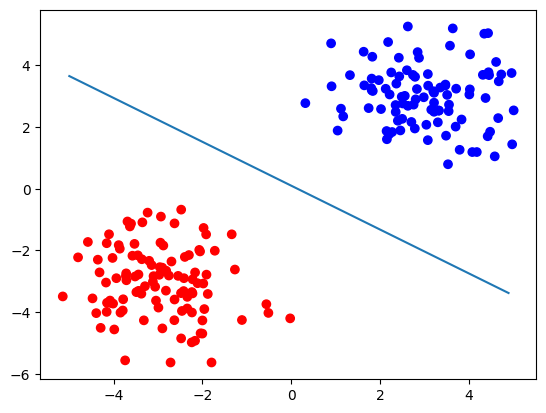

In [19]:
trace_droite(w_sol)
_=plt.scatter(X[:, 0], X[:, 1], c=couleur)

# II. Classifier des images

## 1. Obtention des données : Importer le jeu de données MNIST

On va résoudre un problème similaire, sauf que cette fois les données ne sont plus des points $x_i \in \mathbb{R}^2$ rouges ou bleus, mais des images $x_i \in \mathbb{R}^{64}$ de chiffres écrits à la main.
On ne parlera donc plus de "droite séparatrice" mais d'"hyperplan séparateur".

| Un nouveau jeu de données | 
| ----------- |
| ![](images/mnist.jpg) |
| Chaque image de $8\times 8$ pixels est représentée par un point $x_i \in \mathbb{R}^{64}$ |

Pour ce TP on va se contenter de séparer des images de 0 et de 1. Leurs étiquettes $y_i$ prendront respectivement les valeurs $-1$ et $+1$.



In [20]:
import sklearn.datasets
import sklearn.model_selection

In [21]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['image.cmap'] = 'gray_r'

In [22]:
digits = sklearn.datasets.load_digits() # Importe un jeu de données à classer (10 classes)
digits.data = digits.data*1/np.max(digits.data) # normalise : coeffs dans [0,1]
classes = [0, 1] # Définit les 2 classes de nombres avec lesquelles on va travailler
idx_classes = np.logical_or(digits.target == classes[0], digits.target == classes[1]) # Localise les deux classes ..
digits.data = digits.data[idx_classes] # .. les extrait ..
digits.target = digits.target[idx_classes] # .. et jette le reste
digits.target = np.where(digits.target==classes[0],-1, 1) # Transforme les étiquettes de classes en {-1,+1}

X, X_test, Y, Y_test = sklearn.model_selection.train_test_split( # On coupe le jeu de données en deux
                        digits.data, digits.target, train_size=25, shuffle=True)

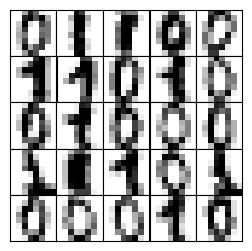

In [23]:
# Affiche les 25 premières images de X
fig, axs = plt.subplots(5, 5, figsize=(3, 3))
for i in range(5):
    for j in range(5):
        k = i*5 + j
        _ = axs[i,j].imshow(X[k].reshape(8,8))
plt.subplots_adjust(wspace=0, hspace=0)

**1)** On dispose de données `X`, qui contient des images de 0 et 1 écrits à la main. Plus précisément, pour tout `k`, `X[k]` représente une telle image 2D (8x8 pixels) qui a été aplatie en un vecteur 1D.

Utiliser `.shape` pour déterminer le nombre d'images que contient `X`.

Prendre une image au hasard, et l'afficher avec la fonction `plt.imshow()`. Afin de l'afficher, vous aurez besoin de temporairement remettre cette image sous forme 2D avec la méthode `.reshape(nb_lignes, nb_colonnes)` . Est-ce l'image d'un 0 ou d'un 1?

In [24]:
X.shape

(25, 64)

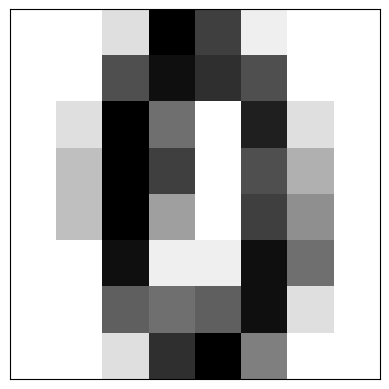

In [25]:
plt.imshow(X[10].reshape(8,8))

**2)** On dispose d'étiquettes `Y` qui encodent la nature des images contenues dans `X`. Plus précisément, `Y[k]` contient `-1` si `X[k]` est l'image d'un 0, ou `+1` si `X[k]` est l'image d'un 1.

Reconsidérer l'image affichée à la question précédente, et vérifier que son étiquette correspond à ce que vous avez observé.

In [26]:
Y[10]

-1

## 2. Phase d'entraînement : Trouver un classifieur avec la méthode SVM

**0)** Définir `m` le nombre de données dans notre jeu de données ; et `d` la taille de chacune de ces données.

In [27]:
m = X.shape[0]
d = X.shape[1]

**1)** Nous allons trouver un classifieur linéaire avec la méthode SVM, comme au I.

Pour ce faire, définir deux vecteurs `e`$= (1, \dots , 1)^\top$, `infini`$=(+\infty, \dots, +\infty)^\top$ de $\mathbb{R}^m$, ainsi que la matrice $\Phi \in \mathcal{M}_{m,d+1}(\mathbb{R})$ définie en Section I.2. 

In [28]:
e = np.ones(m)

In [29]:
Phi = np.zeros((m, d+1)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # dernière colonne remplie par des 1
Phi = np.diag(Y)@Phi # on multiplie chaque ligne par y_i

In [30]:
infini = e*np.inf

**2)** Définir une fonction `objectif` qui prend en entrée un vecteur $w=(a,b) \in \mathbb{R}^{d} \times \mathbb{R}$ et qui renvoie $\Vert a \Vert^2$.

In [31]:
def objectif(w):
    return np.sum(w**2) - w[-1]**2

**3)** Définir `C`, qui représente la contrainte linéaire $e \preceq \Phi w$.

In [32]:
C = LinearConstraint(Phi, e, infini)

**4)** Utiliser la fonction `minimize` de `scipy.optimize` pour trouver `w`, le minimiseur de `objectif` sous la contrainte `C`.

In [33]:
w = minimize(fun = objectif, 
               constraints = C,
               x0 = np.zeros(d+1),
              ).x

**5)** Ecrire une fonction `classifieur`, qui:
- prend en entrée une image aplatie `x`$\in \mathbb{R}^d$
- prend en entrée un vecteur de paramètres  `w`$=(a,b)\in \mathbb{R}^d \times \mathbb{R}$
- retourne +1 si $\langle a, x \rangle + b \geq 0$, -1 sinon

In [34]:
def classifieur(x, w):
    a = w[:-1]
    b = w[-1]
    return np.sign( a.T@x + b )

**6)** Prendre une image au hasard dans `X`, et comparer sa vraie étiquette avec la prédiction faite par notre nouveau classifieur. Notre prédiction est elle bonne?

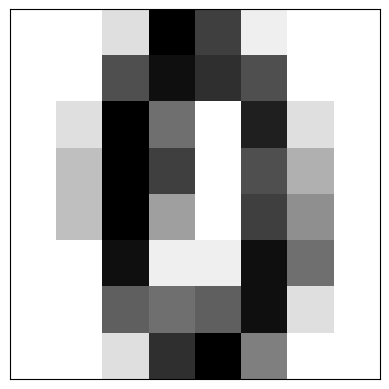

In [35]:
Y[10]
classifieur(X[10], w)
plt.imshow(X[10].reshape(8,8))

## 3. Phase de test : connaitre la vraie performance de notre classifieur

On vient de voir que notre classifieur marche bien lorsque on l'applique aux images contenues dans `X`. Or ceci n'est pas très surprenant : le classifieur a été construit à partir de `w_MNIST`, la solution d'un problème d'optimisation dépendant des données contenues dans `X,Y`. Pour vraiment déterminer si notre modèle a **appris** quelque chose, il faut le tester sur des données qu'il n'a encore **jamais vues**.

On va donc maintenant utiliser les données de test `X_test` et `Y_test` que l'on a pas encore utilisées.

**1)** Calculer le pourcentage de bonnes réponses données par notre `classifieur`. Autrement dit, vous allez parcourir l'ensemble des données de test, et calculer le pourcentage du nombre de fois que le classifieur donne la bonne prédiction, en la comparant à la vraie étiquette contenue dans `Y_test`. Que pensez-vous du nombre obtenu?

In [36]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur(X_test[k], w) == Y_test[k]:
        good = good + 1
good/nb_test

0.9970149253731343

In [37]:
nb_test

335

**2)** Si le taux de bonne réponse n'est pas de 100%, essayez de trouver dans le jeu de données quelles sont les images sur lesquelles le classifieur se trompe.

In [38]:
prediction = np.array([classifieur(X_test[k], w) for k in range(nb_test)])

In [39]:
np.where(Y_test != prediction)[0]

array([53], dtype=int64)

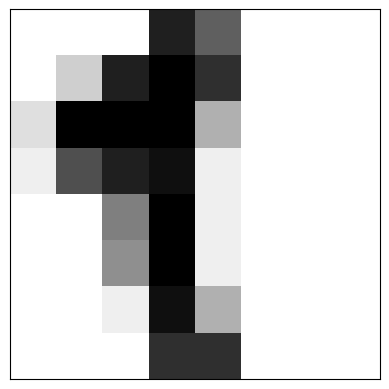

In [40]:
n = np.where(Y_test != prediction)[0][0]
classifieur(X_test[n,:], w)
Y_test[n]
_ = plt.imshow(X_test[n].reshape(8,8))

**3)** Si vous retournez au début de la section **II.**, vous pouvez voir qu'au moment de l'importation nous avons demandé à travailler avec les `classes` 0 et 1.

Remplacez ces chiffres par deux autres chiffres de votre choix, et relancez votre code afin de déterminer le taux de bonne réponse du classifieur. Essayez de prendre des chiffres difficiles à classer!

# III. Pour aller plus loin : Classification multiple

On a vu comment classer des données à deux étiquettes. Mais en pratique il y a souvent un plus grand nombre de classes : par exemple MNIST peut contenir jusqu'à 10 classes: les chiffres de 0 à 9! Un tel classifieur vous est par exemple mis à disposition sur [ce site](https://mco-mnist-draw-rwpxka3zaa-ue.a.run.app/), qui vous permet de dessiner en ligne un chiffre et vous fournira en temps réel une estimation de la probabilité d'appartenance à une classe de chiffre.

Je vous propose dans cette section de construire un tel classifieur. Notre stratégie va consister à réunir plusieurs classifieurs à deux classes (que vous avez appris à construire dans la section précédente) pour construire un classifieur à 10 classes. 
Plus précisément notre stratégie sera:

- Couper le jeu de données en deux classes : les 0 et le reste (1, ..., 9). On produit alors un classifieur qui sera capable de savoir si une image est un zéro, ou non.
- On refait la même chose en isolant cette fois 1 versus le reste (0,2, ..., 9). Et ainsi de suite. Ce qui nous donnera 10 classifieurs, chacun répondant à la question "est-ce que cette image est un 0? un 1? etc.
- Etant donné une nouvelle image, on la passe dans les 10 classifieurs, et en fonction des 10 prédictions on prend une décision.




## 1. Manipulation des données et construction du premier classifieur

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.model_selection
from scipy.optimize import LinearConstraint, minimize

In [42]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['image.cmap'] = 'gray_r'

In [43]:
digits = sklearn.datasets.load_digits() # Importe un jeu de données à classer (10 classes)
digits.data = digits.data*1/np.max(digits.data) # normalise : coeffs dans [0,1]
X, X_test, Y, Y_test = sklearn.model_selection.train_test_split( # On coupe le jeu de données en deux
                        digits.data, digits.target, train_size=0.25, shuffle=True)
etiquettes_original = Y

**1)** Déterminer `m` le nombre de données contenues dans `X`, et `d` la dimension de ces données.

In [44]:
m = X.shape[0]
d = X.shape[1]

**2)** Vérifier que `Y` contient bien des étiquettes allant de 0 à 9. Dans le but de classer les 0 vs. le reste, créez un nouveau vecteur d'étiquettes `Y_temp` qui vaut +1 pour les 0, et -1 pour le reste. Faites bien attention à ne pas modifier le `Y` original!

In [45]:
# 0 vs le reste
cible = 0
Y_temp = np.where(etiquettes_original==cible, 1, -1) # Transforme 'cible' en +1, le reste en -1

**3)** En vous inspirant de ce que vous avez fait à la section précédente:

- définissez le problème de SVM associé au problème de classifier 0 vs. le reste
- résolvez-le, afin d'obtenir `w` un vecteur de paramètres définissant un hyperplan qui sépare les 0 des autres chiffres

In [46]:
def objectif(w):
    return np.sum(w**2) - w[-1]**2

In [47]:
e = np.ones(m)
infini = e*np.inf

Phi = np.zeros((m, d+1)) # matrice vide
Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
Phi[:, -1] = e # dernière colonne remplie par des 1
Phi = np.diag(Y_temp)@Phi # on multiplie chaque ligne par y_i

C = LinearConstraint(Phi, e, infini)

In [48]:
w = minimize(fun = objectif, constraints = C, x0 = np.zeros(d+1)).x

**4)** Prenez quelques examples dans `X` et vérifiez que `w` définit un hyperplan qui sépare bien les 0 du reste (cf. section précédente). Rappelez-vous que les vraies étiquettes sont contenues dans `Y`.

In [49]:
a = w[:-1]
b = w[-1]

In [50]:
x = X[12]
Y[12]
np.sign(a.T@x + b)

-1.0

## 2. Construction d'un classifieur général

**1)** Ici vous devrez reproduire ce que vous venez de faire :

- Pour chaque chiffre 'cible' entre 0 et 9:
  - Définir un vecteur d'étiquettes décrivant un problème de classification 'cible' vs. le reste
  - Définir le problème SVM associé et le résoudre, ce qui vous donnera un vecteurs de paramètres w
  - Ranger chacun de ces vecteurs $w \in \mathbb{R}^{d+1}$ comme ligne d'une matrice $W \in \mathcal{M}_{10, d+1}(\mathbb{R})$

In [51]:
W = np.zeros((10, d+1))
for cible in range(10):
    Y_temp = np.where(etiquettes_original==cible, 1, -1) # Transforme 'cible' en +1, le reste en -1
    e = np.ones(m)
    infini = e*np.inf
    Phi = np.zeros((m, d+1)) # matrice vide
    Phi[:, 0:-1] = X # toutes les colonnes sauf une remplies par X
    Phi[:, -1] = e # dernière colonne remplie par des 1
    Phi = np.diag(Y_temp)@Phi # on multiplie chaque ligne par y_i
    C = LinearConstraint(Phi, e, infini)
    w = minimize(fun = objectif, constraints = C, x0 = np.zeros(d+1)).x
    W[cible, :] = w

**2)** Vérifiez que la matrice `W` obtenue donne de bons résultats. Pour cela, pous pourrez prendre une image quelconque, et la passer dans le classifieur binaire pour chaque ligne de `W` : il devrait renvoyer +1 seulement pour le bon indice.

In [52]:
Y[12]
[ classifieur(X[12], W[i,:]) for i in range(10) ]

[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

**3)** Définir une fonction `classifieur_general` qui:

- prend en entrée une donnée $x$ et une matrice de paramètres  $W \in \mathcal{M}_{10, d+1}(\mathbb{R})$
- pour chaque chiffre `i` entre 0 et 9, utilise le classifieur binaire induit par `W[i,:]` pour déterminer si $x$ est égal à `i` ou non
- renvoie `i` si $x$ est égal à `i`
- pensez à faire en sorte que la fonction renvoie toujours quelque chose

Vous testerez sur un exemple que cela marche bien.

In [53]:
def classifieur_general(x, W):
    A = W[:, :-1]
    B = W[:, -1]
    evaluation = A@x + B
    class_vs = np.sign(evaluation) # vecteur de -1 et +1
    return np.argmax(class_vs)

In [54]:
Y[12]
classifieur_general(X[12], W)

4

**4)** Appliquez votre `classifieur_general` aux données de test, comme au **II.3.1)**. Quel est le pourcentage de bonnes réponses de votre classifieur? Que pensez-vous du résultat?

In [55]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur_general(X_test[k], W) == Y_test[k]:
        good = good + 1
good/nb_test

0.8761127596439169

## 3. Construction d'un classifieur général amélioré

Le classifieur précédent souffre de quelques défauts.
Par exemple, si une image est classée comme appartenant à deux classes, comment choisir laquelle des deux est la meilleure?
Et si une image apparait classée comme appartenant à aucune classe, comment choisir quelle classe est la moins mauvaise?
On donc besoin que les classifieurs binaires renvoient un peu plus que une réponse $\pm 1$ pour chaque chiffre : il nous faut également un indice de confiance, une *probabilité* que la réponse $\pm 1$ soit correcte.

Par exemple, imaginons que le classifieur biniaire "0 vs. le reste" nous dise que $\mathbb{P}(x=0) = 0.4$. Dans ce cas on pourrait conclure que $x$ n'est pas un 0, puisque $\mathbb{P}(x\neq 0) = 0.6$. Mais si tous les autres classifieurs binaires nous disent également que $\mathbb{P}(x=k) = 0.01$, alors on pourrait se dire que 0 est la moins mauvaise réponse.

Pour notre problème, cette probabilité va être liée à la distance entre la donnée $x$ et l'hyperplan séparateur $H_w$ : plus la donnée est proche de l'hyperplan, et moins on aura confiance en la prédiction, donc plus basse sera la probabilité.

**1)** Définir une fonction `classifieur_general2` qui reprend le principe de `classifieur_general`. Cette fois-ci, l'indice `i` renvoyé sera selui qui maximise la probabilité $p_i$, où $p \in \mathbb{R}^{10}$ est défini par :

$$ p_i := \frac{e^{v_i}}{\sum\limits_{j=1}^p e^{v_j}},
\quad
v_i := \langle a^i, x \rangle + b^i
$$
avec `W[i,:]`$=(a^i, b^i)$. 
Vous testerez sur un exemple que votre fonction marche bien.

In [56]:
def softmax(v):
    s = np.sum(np.exp(v))
    return np.exp(v)/s

In [57]:
def classifieur_general2(x, W):
    A = W[:, :-1]
    B = W[:, -1]
    evaluation = A@x + B
    confiance = softmax(evaluation)
    etiquette = np.argmax(confiance)
    return etiquette

In [58]:
classifieur_general2(X[12], W)

4

**2)** Estimer la performance de votre nouveau classifieur sur les données de test. Comparer avec le classifieur précédent. 

In [59]:
good = 0
nb_test = X_test.shape[0]
for k in range(nb_test):
    if classifieur_general2(X_test[k], W) == Y_test[k]:
        good = good + 1
good/nb_test

0.9280415430267063

**Pour aller plus loin:** 

- Rien ne vous empêche de dessiner vos propres chiffres, et de tester si votre classifieur le reconnait.. Pour cela il vous suffit de produire une image carrée, de la redimensionner en image 8x8, puis de l'importer dans python.
- Il existe d'autres façons de faire de la classification multiclasse. C'est simplement et rapidement expliqué dans [ce cours en ligne](https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/4507846-classifiez-vos-donnees-en-plus-de-deux-classes) de Chloé-Agathe Azencott.

**Notes**

Ressources utilisées pour charger et utiliser MNIST:

- https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html
- https://towardsdatascience.com/support-vector-machine-mnist-digit-classification-with-python-including-my-hand-written-digits-83d6eca7004a
- https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html